In [18]:
### Loading required libraries

from    pandas             import   read_csv, Grouper, DataFrame, concat
import  matplotlib.pyplot  as       plt
import  statsmodels.api          as       sm
from   sklearn.metrics      import  mean_squared_error
from   statsmodels.tsa.holtwinters     import  SimpleExpSmoothing,Holt, ExponentialSmoothing
import statsmodels.tsa.holtwinters     as      ets
import statsmodels.tools.eval_measures as      fa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
%matplotlib inline

In [19]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas import Series

In [20]:
# Read the time series data
# We set parse_dates to make sure data is read as time-series and make time column as Index
# We drop the id column, which is not usefull for us.
predice = pd.read_csv('Desktop/train_csv.csv', header = 0, index_col = 1, parse_dates = True, squeeze = True)
predice.drop(['id'],axis = 1,inplace = True)

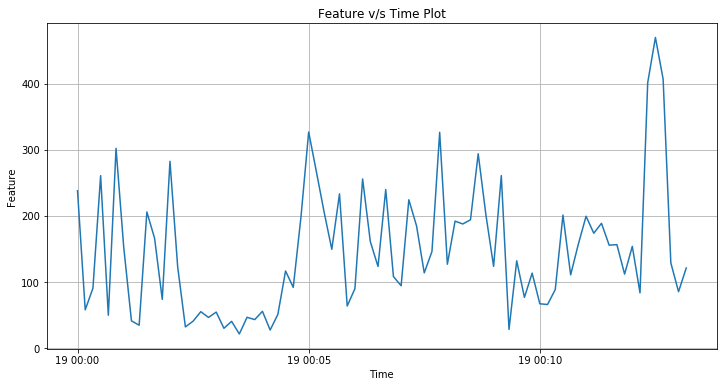

In [21]:
plt.figure(figsize=(12,6))
plt.plot(predice.index, predice['feature'])
plt.title('Feature v/s Time Plot')
plt.xlabel('Time')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

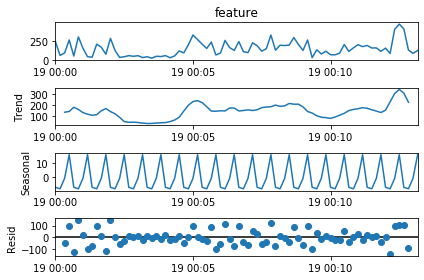

In [22]:
decompPred = sm.tsa.seasonal_decompose(predice.feature, model="additive", freq=4)
decompPred.plot()
plt.show()

In [23]:
#Splitting data to Test:Train
train = predice[0:int(len(predice)*0.7)] 
test = predice[int(len(predice)*0.7):]


In [24]:
# extract out the time-series
feature_ts_train =  train['feature']
feature_ts_test =  test['feature']

In [25]:
dftest = adfuller(feature_ts_train)
dftest
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])


DF test statistic is -2.019
DF test p-value is 0.2782


Text(0, 0.5, 'Feature')

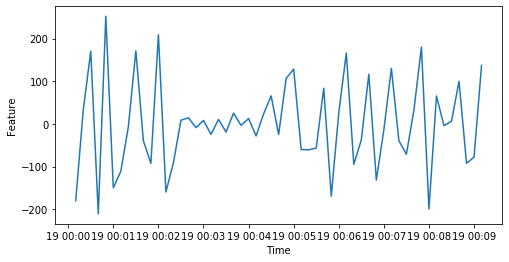

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(feature_ts_train.diff(periods=1))
plt.xlabel('Time')
plt.ylabel('Feature')

In [27]:
feature_ts_train_diff = feature_ts_train.diff(periods=1)
feature_ts_train_diff.dropna(inplace=True)

feature_ts_test_diff = feature_ts_test.diff(periods=1)
feature_ts_test_diff.dropna(inplace=True)

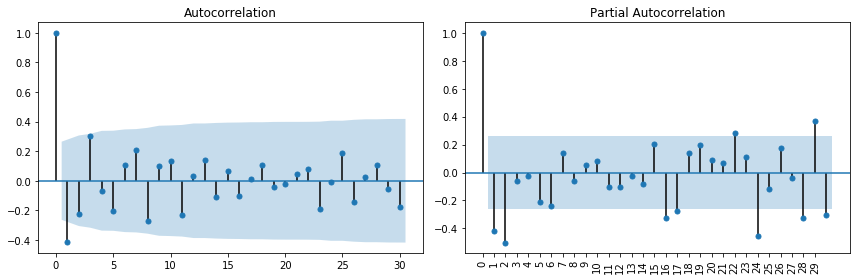

In [28]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(feature_ts_train_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(feature_ts_train_diff, lags=30, ax=axes[1])
plt.tight_layout()

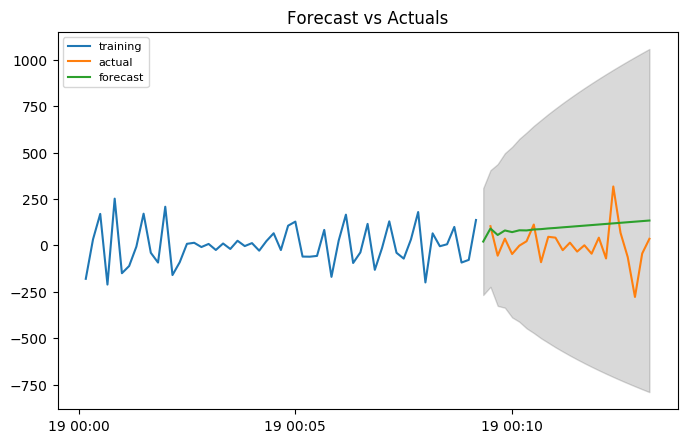

In [29]:
# Build Model 
model = ARIMA(feature_ts_train_diff, order=(1, 1, 0)) #Chosen this combination of p,q,d after trying other combinations 
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(24, alpha=0.05)  

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(feature_ts_train_diff, label='training')
plt.plot(feature_ts_test_diff, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
forecast = fitted.forecast(steps=40)[0]
predice_to_pred = pd.read_csv('Desktop/test_csv.csv')
predice_to_pred['forecast'] = forecast
predice_to_pred.head()


,id,time,forecast
0,80,2019-03-19 00:13:20,20.873555
1,81,2019-03-19 00:13:30,91.167510
2,82,2019-03-19 00:13:40,56.369289
3,83,2019-03-19 00:13:50,80.751980
4,84,2019-03-19 00:14:00,71.807924


In [31]:
#Akaike's Information Criterion (AIC) ; lower the value better is the ARIMA Model
fitted.aic

698.6304123533189